<h1 style="text-align: center;">Formula 1 Race predictor</h1>

<h3 style="text-align: center; font-weight: normal; color: gray;">Petar Stamenkovic &nbsp; | &nbsp; Aleksa Mitrovcan</h3>

<img src="Image/lec.jpeg" style="display: block; margin-left: auto; margin-right: auto; width: 100%;" />



## Intro

Hello everyone! This is our second project together, and we decided to try something different when it comes to Formula 1. In this notebook, we will use Gradient Boosting (specifically XGBoost) to try and predict the final race position for each driver on the grid. The user will input a track for prediction and fetch data for each year from 2022 to 2024 if the race happened in any of those years. We feel like the 3-year gap is solid, but this could be easily modified if you wish, simply by calling a certain function a couple more times.

For this project, just like with the previous one, we used Python and Jupyter Notebook for better user readability of the final product. Image below shows the basic way XGBoost works.

<img src="Image/xgb.png" style="display: block; margin-left: auto; margin-right: auto; width: 100%;" />


## Importing packages

Firstly, we want to import all necessary packages. We will use Fast F1 for Python and sklearn package that contains some elementary functions for machine learning model creation. 

After importing, we enable caching, so that data fetching process is faster. Then we import our Driver data table, that contains each driver experience in number of race starts, and we set a track name for prediction. 

In [1]:
# Importing all packages and loading neccesary data
import os
import fastf1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import shutil

# Enable cache memory for faster access
custom_cache_folder = "f1_cache"
os.makedirs(custom_cache_folder, exist_ok=True)
fastf1.Cache.enable_cache(custom_cache_folder)

# Import driver info table containing years of experience for each driver
experience = pd.read_csv("Dataset/DriverInfo.csv")

# Set a race name for prediction 
circuit_name = "Japanese Grand Prix"

## Necessary functions

For the better scalability and modularity, we created functions for fetching our data. Please be aware that fast f1 will **autocorrect** your input in case the race did not happen in one of the years. For example, Chinese Grand Prix was not held in 2022, so fast f1 will change it to Japanese Grand Prix, for that year only. Obviously, we do not want this to happen, as that means we are corrupting our training set. Unfortunately, this does mean that for some races, MAE score will be worse and result in less accurate predictions, but as mentioned, this can be possibly improved by adding more years into the mix.

In [2]:
# This function ensures that right races are loaded in training set
# In case that selected race did not happen in one of 3 years we skip it
def race_exists(year, circuit):
    try:
        schedule = fastf1.get_event_schedule(year)
        circuit_lower = circuit.strip().lower()
        event_names = schedule['EventName'].str.strip().str.lower()
        return circuit_lower in event_names.values
    except Exception as e:
        print(f"Error checking race schedule for {year}: {e}")
        return False

# This function fetches selected race data and creates a data frame        
def get_race_data(year, circuit):
    if not race_exists(year, circuit):
        print(f"Race '{circuit}' not found in {year}. Skipping.")
        return pd.DataFrame()

    try:
        # Fast F1 API main call
        session = fastf1.get_session(year, circuit, 'R')
        session.load()

        # Loading all driver lap values
        all_drivers = session.laps["Driver"].unique()
        fastest_laps = []
        
        # Fetching fastest laps for all drivers
        for driver in all_drivers:
            try:
                driver_laps = session.laps.pick_drivers(driver)
                if not driver_laps.empty:
                    fastest_lap = driver_laps.pick_fastest()
                    if not pd.isna(fastest_lap['LapTime']):
                        fastest_lap_seconds = fastest_lap['LapTime'].total_seconds()
                        fastest_laps.append([driver, fastest_lap_seconds])
                    else:
                        fastest_laps.append([driver, None])
                else:
                    fastest_laps.append([driver, None])
            except Exception as e:
                print(f"Error processing driver {driver} in {year}: {e}")
                fastest_laps.append([driver, None])

        fastest_lap_df = pd.DataFrame(fastest_laps, columns=["Abbreviation", "FastestLap"])

        # Extract only necessary information from inital table
        results = session.results[["FullName", "Abbreviation", "TeamName", "GridPosition", "Position", "Status"]]
        results["Year"] = year
        
        # Loading weather information and calculating average values
        weather_data = session.weather_data
        results["Humidity"] = weather_data["Humidity"].mean()
        results["Temperature"] = weather_data["AirTemp"].mean()
        results["Rain"] = weather_data["Rainfall"].mean()

        results = results.merge(fastest_lap_df, on="Abbreviation")
        return results
    
    except Exception as e:
        print(f"Error getting race data for {year} {circuit}: {e}")
        return pd.DataFrame()

        
# This function fetches qualifing data
def get_qualifying_data(year, circuit):
    
    if not race_exists(year, circuit):
        print(f"Race '{circuit}' not found in {year}. Skipping.")
        return pd.DataFrame()
    
    try:
        session = fastf1.get_session(year, circuit, 'Q')
        session.load()

        all_drivers = session.laps["Driver"].unique()
        qualifying_data = []

        for driver in all_drivers:
            try:
                driver_laps = session.laps.pick_drivers(driver)
                if not driver_laps.empty:
                    fastest_lap = driver_laps.pick_fastest()
                    qualifying_time = fastest_lap['LapTime'].total_seconds() if 'LapTime' in fastest_lap else None
                    speed_trap = fastest_lap['SpeedI2'] if 'SpeedI2' in fastest_lap else None
                else:
                    qualifying_time = None
                    speed_trap = None
                
                qualifying_data.append([driver, qualifying_time, speed_trap])
            except Exception as e:
                print(f"Error processing driver {driver} in {year}: {e}")
                qualifying_data.append([driver, None, None])

        qualifying_df = pd.DataFrame(
            qualifying_data,
            columns=["Abbreviation", "QualifyingTime", "SpeedTrapQualy"]
        )
        
        results = session.results[["Abbreviation", "Position"]]
        results = results.rename(columns={"Position": "QualifyingPosition"})
        qualifying_results = results.merge(qualifying_df, on="Abbreviation")
        qualifying_results["Year"] = year
        
        return qualifying_results
    
    except Exception as e:
        print(f"Error getting qualifying data for {year} {circuit}: {e}")
        return pd.DataFrame()

## Function calls 

This is where we call our functions for data fetching and data frame creation. Here is the chance to increase the number of years for your model training, if necessary.

In [3]:
# Get data for all years for both races and qualifying
#race_2022 = get_race_data(2022, circuit_name)
race_2023 = get_race_data(2023, circuit_name)
race_2024 = get_race_data(2024, circuit_name)

#quali_2022 = get_qualifying_data(2022, circuit_name)
quali_2023 = get_qualifying_data(2023, circuit_name)
quali_2024 = get_qualifying_data(2024, circuit_name)

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '2

Error processing driver RIC in 2024: 'NoneType' object is not subscriptable
Error processing driver ALB in 2024: 'NoneType' object is not subscriptable


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '16', '11', '55', '44', '63', '22', '14', '40', '10', '23', '31', '20', '77', '18', '27', '24', '2']
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Error processing driver SAR in 2023: argument of type 'NoneType' is not iterable


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '55', '14', '81', '44', '16', '63', '22', '3', '27', '77', '23', '31', '18', '10', '20', '2', '24']


## Format and merge necessary data

After fetching the data, we merge them all in one big final Data Frame. Merge is mostly done on driver Abbreviations. For features Time Ratio and Speed Trap, we group our entries by drivers and calculate the mean values for each one. This is later used in the prediction sample.

In [4]:
# Combine all data
all_races = pd.concat([race_2023, race_2024], ignore_index=True)
all_qualis = pd.concat([quali_2023, quali_2024], ignore_index=True)

# Merge race and qualifying data
merged_data = pd.merge(
    all_races,
    all_qualis,
    on=["Abbreviation", "Year"],
    how="left"
)

# Add driver experience information
final_data = merged_data.merge(experience, on=["Abbreviation"])

# Calculate TimeRatio (QualifyingTime / FastestLap)
final_data["TimeRatio"] = final_data.apply(
    lambda row: row["QualifyingTime"] / row["FastestLap"] 
    if pd.notna(row["QualifyingTime"]) and pd.notna(row["FastestLap"]) and row["FastestLap"] != 0 
    else None,
    axis=1
)

# Clean up the final DataFrame and reorganize it
final_data = final_data[[
    'Year', 'FullName', 'Abbreviation', 'TeamName', 
    'QualifyingPosition', 'GridPosition', 'Position',
    'QualifyingTime', 'FastestLap', 'TimeRatio', 'SpeedTrapQualy',
    'Temperature', 'Humidity', 'Rain', 'Status','NumberOfRaces'
    # Add any columns from experience.csv that you need
]]

# This mapping is neccesary since these teams changed names during these years
team_mappings = {
    'Alfa Romeo': 'Kick Sauber',
    'AlphaTauri': 'RB'
}

final_data['TeamName'] = final_data['TeamName'].replace(team_mappings)
final_data

,Year,FullName,Abbreviation,TeamName,QualifyingPosition,GridPosition,Position,QualifyingTime,FastestLap,TimeRatio,SpeedTrapQualy,Temperature,Humidity,Rain,Status,NumberOfRaces
0,2023,Max Verstappen,VER,Red Bull Racing,1.0,1.0,1.0,88.877,94.183,0.943663,305.0,27.288608,42.316456,0.0,Finished,211
1,2023,Lando Norris,NOR,McLaren,3.0,3.0,2.0,89.493,95.247,0.939589,307.0,27.288608,42.316456,0.0,Finished,130
2,2023,Oscar Piastri,PIA,McLaren,2.0,2.0,3.0,89.458,96.328,0.928681,307.0,27.288608,42.316456,0.0,Finished,48
3,2023,Charles Leclerc,LEC,Ferrari,4.0,4.0,4.0,89.542,96.362,0.929225,303.0,27.288608,42.316456,0.0,Finished,149
4,2023,Lewis Hamilton,HAM,Mercedes,7.0,7.0,5.0,89.908,95.611,0.940352,303.0,27.288608,42.316456,0.0,Finished,358
5,2023,Carlos Sainz,SAI,Ferrari,6.0,6.0,6.0,89.850,96.187,0.934118,304.0,27.288608,42.316456,0.0,Finished,208
6,2023,George Russell,RUS,Mercedes,8.0,8.0,7.0,90.219,97.653,0.923873,303.0,27.288608,42.316456,0.0,Finished,130
7,2023,Fernando Alonso,ALO,Aston Martin,10.0,10.0,8.0,90.465,97.203,0.930681,304.0,27.288608,42.316456,0.0,Finished,405
8,2023,Esteban Ocon,OCO,Alpine,14.0,14.0,9.0,90.586,97.398,0.930060,307.0,27.288608,42.316456,0.0,Finished,158
9,2023,Pierre Gasly,GAS,Alpine,12.0,12.0,10.0,90.509,96.371,0.939173,304.0,27.288608,42.316456,0.0,Finished,155


## Encoding string type features

Machine learning models do not work with string values, so here we map the drivers manually, since they also changed during our year gap. Teams did not change, so we are free to use Label encoder to do the mapping.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Create a copy so we don't modify the original
final_sessions_encoded = final_data.copy()

# Encoding team names using Label Encoder
label_encoder_team = LabelEncoder()
final_sessions_encoded["TeamName"] = label_encoder_team.fit_transform(final_sessions_encoded["TeamName"])

# Driver mapping
driver_encoding = {
    'ALB': 0,   # Alexander Albon
    'ALO': 1,   # Fernando Alonso
    'BOT': 2,   # Valtteri Bottas
    'COL': 3,   # (Reserved/Historical)
    'DOO': 4,   # (Reserved/Historical)
    'GAS': 5,   # Pierre Gasly
    'HAM': 6,   # Lewis Hamilton
    'HUL': 7,   # Nico Hülkenberg
    'LAT': 8,   # Nicholas Latifi (2022)
    'LAW': 9,   # Liam Lawson (2023 substitute)
    'LEC': 10,  # Charles Leclerc
    'MAG': 11,  # Kevin Magnussen
    'NOR': 12,  # Lando Norris
    'OCO': 13,  # Esteban Ocon
    'PER': 14,  # Sergio Pérez
    'PIA': 15,  # Oscar Piastri
    'RIC': 16,  # Daniel Ricciardo
    'RUS': 17,  # George Russell
    'SAI': 18,  # Carlos Sainz
    'SAR': 19,  # (Reserved/Historical)
    'STR': 20,  # Lance Stroll
    'TSU': 21,  # Yuki Tsunoda
    'VER': 22,  # Max Verstappen
    'VET': 23,  # Sebastian Vettel (retired after 2022)
    'ZHO': 24,  # Zhou Guanyu
    'BEA': 25,  # Oliver Bearman
    'ANT': 26,  # Kimi Antonelli
    'BOR': 27,  # Gabriel Bortoleto
    'HAD': 28   # Isaac Hadjar
}

# Mapping for Teams
team_mapping = dict(zip(label_encoder_team.classes_, label_encoder_team.transform(label_encoder_team.classes_)))
team_df = pd.DataFrame(list(team_mapping.items()), columns=['Team', 'TeamCode'])
print(team_df)

final_sessions_encoded['Abbreviation'] = final_sessions_encoded['Abbreviation'].replace(driver_encoding)

              Team  TeamCode
0           Alpine         0
1     Aston Martin         1
2          Ferrari         2
3     Haas F1 Team         3
4      Kick Sauber         4
5          McLaren         5
6         Mercedes         6
7               RB         7
8  Red Bull Racing         8
9         Williams         9


/tmp/ipykernel_16317/2383988003.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_sessions_encoded['Abbreviation'] = final_sessions_encoded['Abbreviation'].replace(driver_encoding)


## Resolve possible NaN values

In a table above, we can see that there are couples of NaN values. Since NaN value are possible to occur here for various reasons like driver not finishing the race or not attending qualification session, we resolve this by calculating the mean value for the problematic column and fill those NaN values. This seems like the valid solution.

In [6]:
# Check for NaN values
print(final_sessions_encoded.isnull().sum())

# Fill NaN values with mean values in those columns
for col in ["QualifyingTime", "FastestLap", "TimeRatio", "SpeedTrapQualy"]:
    final_sessions_encoded[col] = final_sessions_encoded[col].fillna(final_sessions_encoded[col].mean())

# Verify that there are no NaN values
print(final_sessions_encoded.isnull().sum())

# Calculate and print mean trap speed for each driver - this is visualy easier for creating prediction sample
mean_speeds = final_sessions_encoded.groupby('FullName')['SpeedTrapQualy'].mean().reset_index()
print("Mean speeds are: ", mean_speeds)

# Calculate and print time ratio for each driver - this is visualy easier for creating prediction sample
mean_time_ratio = final_sessions_encoded.groupby('FullName')['TimeRatio'].mean().reset_index()
print("Mean time ratio's are: ", mean_time_ratio)

# Calculating mean values and importing them into Data Frame
final_sessions_encoded['MeanSpeedTrap'] = final_sessions_encoded.groupby('FullName')['SpeedTrapQualy'].transform('mean')
final_sessions_encoded['MeanTimeRatio'] = final_sessions_encoded.groupby('FullName')['TimeRatio'].transform('mean')
final_sessions_encoded['YearWeight'] = final_sessions_encoded['Year'].map({2024: 5, 2023: 3, 2022: 0.1})

final_sessions_encoded

Year                  0
FullName              0
Abbreviation          0
TeamName              0
QualifyingPosition    0
GridPosition          0
Position              0
QualifyingTime        1
FastestLap            2
TimeRatio             3
SpeedTrapQualy        1
Temperature           0
Humidity              0
Rain                  0
Status                0
NumberOfRaces         0
dtype: int64
Year                  0
FullName              0
Abbreviation          0
TeamName              0
QualifyingPosition    0
GridPosition          0
Position              0
QualifyingTime        0
FastestLap            0
TimeRatio             0
SpeedTrapQualy        0
Temperature           0
Humidity              0
Rain                  0
Status                0
NumberOfRaces         0
dtype: int64
Mean speeds are:              FullName  SpeedTrapQualy
0    Alexander Albon      305.000000
1       Carlos Sainz      300.000000
2    Charles Leclerc      299.000000
3   Daniel Ricciardo      297.000000
4  

,Year,FullName,Abbreviation,TeamName,QualifyingPosition,GridPosition,Position,QualifyingTime,FastestLap,TimeRatio,SpeedTrapQualy,Temperature,Humidity,Rain,Status,NumberOfRaces,MeanSpeedTrap,MeanTimeRatio,YearWeight
0,2023,Max Verstappen,22,8,1.0,1.0,1.0,88.877000,94.183000,0.943663,305.000000,27.288608,42.316456,0.0,Finished,211,301.000000,0.942436,3.0
1,2023,Lando Norris,12,5,3.0,3.0,2.0,89.493000,95.247000,0.939589,307.000000,27.288608,42.316456,0.0,Finished,130,302.500000,0.934616,3.0
2,2023,Oscar Piastri,15,5,2.0,2.0,3.0,89.458000,96.328000,0.928681,307.000000,27.288608,42.316456,0.0,Finished,48,301.500000,0.932474,3.0
3,2023,Charles Leclerc,10,2,4.0,4.0,4.0,89.542000,96.362000,0.929225,303.000000,27.288608,42.316456,0.0,Finished,149,299.000000,0.931691,3.0
4,2023,Lewis Hamilton,6,6,7.0,7.0,5.0,89.908000,95.611000,0.940352,303.000000,27.288608,42.316456,0.0,Finished,358,300.000000,0.942577,3.0
5,2023,Carlos Sainz,18,2,6.0,6.0,6.0,89.850000,96.187000,0.934118,304.000000,27.288608,42.316456,0.0,Finished,208,300.000000,0.939571,3.0
6,2023,George Russell,17,6,8.0,8.0,7.0,90.219000,97.653000,0.923873,303.000000,27.288608,42.316456,0.0,Finished,130,301.000000,0.933357,3.0
7,2023,Fernando Alonso,1,1,10.0,10.0,8.0,90.465000,97.203000,0.930681,304.000000,27.288608,42.316456,0.0,Finished,405,301.500000,0.933459,3.0
8,2023,Esteban Ocon,13,0,14.0,14.0,9.0,90.586000,97.398000,0.930060,307.000000,27.288608,42.316456,0.0,Finished,158,302.500000,0.931668,3.0
9,2023,Pierre Gasly,5,0,12.0,12.0,10.0,90.509000,96.371000,0.939173,304.000000,27.288608,42.316456,0.0,Finished,155,300.500000,0.935838,3.0


## Scale values for temperature, humidity and fastest lap

Most of the time, scaling gives an improvement on model's accuracy. We imported a Standard Scaler and scaled down the features that have the most different ranges.

In [7]:
# Import Standard Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Create Scaler instances
scaler = StandardScaler()
fastest_lap_scaler = MinMaxScaler()

# Scaling Features - These will not be in X_2025 DataFrame so they are scaled separetly
features_to_scale = ['Temperature', 'Humidity', 'NumberOfRaces', 'MeanSpeedTrap']
final_sessions_encoded[features_to_scale] = scaler.fit_transform(final_sessions_encoded[features_to_scale])

# Scaling Lap Times
final_sessions_encoded['FastestLap'] = fastest_lap_scaler.fit_transform(final_sessions_encoded[['FastestLap']])

# Check if the scaling worked
print(final_sessions_encoded[['Temperature', 'Humidity', 'FastestLap','NumberOfRaces', 'MeanSpeedTrap']].head())


   Temperature  Humidity  FastestLap  NumberOfRaces  MeanSpeedTrap
0          1.0      -1.0    0.016421       0.371178      -0.013218
1          1.0      -1.0    0.053048      -0.462236       0.760026
2          1.0      -1.0    0.090261      -1.305939       0.244530
3          1.0      -1.0    0.091432      -0.266744      -1.044210
4          1.0      -1.0    0.065579       1.883669      -0.528714


## Creating and training a model

As we mentioned, for this project we decided to use Gradient Boosting, more precisely XGBoost. Here you can see the basic steps in creating and fitting a model. The explanation of features will be available in provided documentation. Please be aware that MAE will vary since not every race happened in every year from selected period. Some races only happened once in three previous years, so the training set will be smaller, causing MAE to increase.

In [8]:
# List of all used features - they are explained in the provided documentation
features = ['Abbreviation', 'YearWeight','TeamName', 'GridPosition', 'QualifyingTime', 'Temperature', 'Humidity', 'Rain', 'NumberOfRaces','MeanSpeedTrap', 'MeanTimeRatio']

# We are predicting final race position, here we could encode Status as well?
target = 'Position'

# Elementary data sets for machine learning model fitting
X = final_sessions_encoded[features]
y = final_sessions_encoded[target]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

# Training a model
model = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 1)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)
print("Mean Absolute Error for positions: ", mean_absolute_error(y_test,y_pred))

Mean Absolute Error for positions:  2.962085465481372



<p style="text-align: left; font-size: 16px; color: #555; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    With all this data available, we can also predict the fastest lap times of each driver. Let's create another model for that matter! Since times from previous year shift drastically, let's predict a time ratio for this race, and simply calculate the fastest lap for each driver. Let's use a Random Forest this time, for some diversity.
</p>


In [9]:
from sklearn.ensemble import RandomForestRegressor

# Features for time ratio prediction
features_ratio = ['Abbreviation', 'YearWeight','TeamName', 'GridPosition', 'QualifyingTime', 'Temperature', 'Humidity', 'Rain', 'NumberOfRaces','MeanSpeedTrap']

# New target is the time ratio
target_ratio = 'TimeRatio'

# Elementary data sets for machine learning model fitting
X2 = final_sessions_encoded[features_ratio]
y2 = final_sessions_encoded[target_ratio]

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)

# Initialize the RandomForestRegressor model
model2 = RandomForestRegressor(random_state=1)

# Fit the model with the sample weights
model2.fit(X2_train, y2_train)

# Prediction on the test set
y2_pred = model2.predict(X2_test)

# Calculate error metrics
mae = mean_absolute_error(y2_test, y2_pred)
print(f"Mean Absolute Error for time ratio: {mae}")

# Optionally: Display feature importances
importances = model2.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X2.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", feature_importance_df)

Mean Absolute Error for time ratio: 0.011799851278798484
Feature Importances:
           Feature  Importance
4  QualifyingTime    0.286796
0    Abbreviation    0.198392
8   NumberOfRaces    0.129186
9   MeanSpeedTrap    0.114635
3    GridPosition    0.107910
6        Humidity    0.058330
2        TeamName    0.045037
1      YearWeight    0.037405
5     Temperature    0.022309
7            Rain    0.000000



<p style="text-align: left; font-size: 16px; color: #555; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    This does make sense, for a time ratio, qualifying time is the most important thing (it is a direct correlation), after which comes the skill of the actual driver and his experience.
</p>


## Prediction Sample

So far, this prediction sample is created this way, we might try to automate the process in future updates. From the index 0 in each feature's list, we write data for the fastest driver of the qualifying session, then move on to second, and so on. Finally, predictions are available by the end of this cell.

In [10]:
import numpy as np

# Creating a sample dataset for 2025 predictions
data_2025 = {
    "Abbreviation": [22, 12, 15, 10, 17, 26, 28, 6, 0, 25],  # Already encoded driver names
    "YearWeight" : [5] * 10, # Year weight is same for every driver
    "TeamName": [8, 5, 5, 2, 6, 6, 7, 2, 9, 3],  # Already encoded team names
    "GridPosition": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Qualifying grid positions
    "QualifyingTime": [86.983, 86.995, 87.027, 87.299, 87.318, 87.555, 87.569, 87.610, 87.615, 87.867],  # Lap times
    "Temperature": [19] * 10,  # Constant for the race
    "Humidity": [55] * 10,  # Constant for the race
    "Rain": [0.0] * 10,  # No rain
    "NumberOfRaces": [211, 130, 48, 149, 130, 2, 2, 358, 106, 5],
    "MeanSpeedTrap": [324.000000, 318.333333, 321.000000, 320.666667, 319.0000000, 319.000000, 320.666667, 318.666667, 325.0000000, 322.0000000],  # Top speed
    "MeanTimeRatio": [0.947336, 0.951439, 0.947429, 0.943792, 0.948008, 0.948008, 0.942743, 0.952311, 0.951111, 0.936225]  # Lap consistency 
}

# Convert to DataFrame 
X_2025 = pd.DataFrame(data_2025)

# Predict race positions using XGBoost model
y_pred = model.predict(X_2025)

# Clip predictions to ensure valid positions (1–20 for example, we use 10 drivers)
y_pred = np.clip(y_pred, 1, 20)

# Assign predictions back to DataFrame
X_2025["PredictedRacePosition"] = y_pred

# Sort by predicted race position (ensuring ranking is unique)
X_2025 = X_2025.sort_values(by="PredictedRacePosition").reset_index(drop=True)

# Assign unique integer positions (1st to Nth) based on ranking
X_2025["FinalPredictedPosition"] = range(1, len(X_2025) + 1)

# Decode abbreviation from encoded integer back to original string
reverse_driver_encoding = {v: k for k, v in driver_encoding.items()}
X_2025['Abbreviation'] = X_2025['Abbreviation'].map(reverse_driver_encoding)

# Display the final sorted predictions
print(X_2025[['Abbreviation', 'PredictedRacePosition', 'FinalPredictedPosition']])

  Abbreviation  PredictedRacePosition  FinalPredictedPosition
0          VER               2.468560                       1
1          PIA               3.634687                       2
2          NOR               3.638551                       3
3          LEC               4.223218                       4
4          HAM               8.531576                       5
5          ANT               9.317966                       6
6          HAD               9.563536                       7
7          BEA              10.256912                       8
8          ALB              10.356603                       9
9          RUS              13.614749                      10



<p style="text-align: left; font-size: 16px; color: #555; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    We do a similar process, only this time for time ratio prediction. Notice that mean time ratio is not necessary here. Everything else remains the same.
</p>


In [11]:
# Prediction sample for a time ratio
data_2025_time_ratio_sample = {
    "Abbreviation": [22, 12, 15, 10, 17, 26, 28, 6, 0, 25],  # Already encoded driver names
    "YearWeight" : [9] * 10,
    "TeamName": [8, 5, 5, 2, 6, 6, 7, 2, 9, 3],  # Already encoded team names
    "GridPosition": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Qualifying grid positions
    "QualifyingTime": [86.983, 86.995, 87.027, 87.299, 87.318, 87.555, 87.569, 87.610, 87.615, 87.867],  # Lap times
    "Temperature": [19] * 10,  # Constant for the race
    "Humidity": [55] * 10,  # Constant for the race
    "Rain": [0.0] * 10,  # No rain
    "NumberOfRaces": [211, 130, 48, 149, 130, 2, 2, 358, 106, 5],  # Experience (Hadjar = 0)
    "MeanSpeedTrap": [324.000000, 318.333333, 321.000000, 320.666667, 319.0000000, 319.000000, 320.666667, 318.666667, 325.0000000, 322.0000000],  # Top speed
}

# Convert to DataFrame
X_2025_time_ratio = pd.DataFrame(data_2025_time_ratio_sample)

# Predict the time ratio
y2_pred = model2.predict(X_2025_time_ratio)

print(y2_pred)
predicted_fastest_laps = X_2025_time_ratio["QualifyingTime"] / y2_pred

# Input the newly predicted time ratio into resulting Data Frame
X_2025["PredictedFastestLap"] = predicted_fastest_laps

# Function to convert seconds to Min:Sec:Milliseconds
def convert_to_time_format(time_seconds):
    minutes = int(time_seconds // 60)
    seconds = int(time_seconds % 60)
    milliseconds = int((time_seconds - (minutes*60 + seconds))*1000)
    return f"{minutes}:{seconds:02d}:{milliseconds:03d}"

# Apply conversion to the PredictedFastestLap column
X_2025['FormattedFastestLap'] = X_2025['PredictedFastestLap'].apply(convert_to_time_format)

# Print it all out
X_2025[["Abbreviation", "PredictedRacePosition", "FinalPredictedPosition", "PredictedFastestLap", "FormattedFastestLap"]]

[0.9321184  0.92957936 0.93046496 0.92872543 0.93161836 0.93180076
 0.93130103 0.93033493 0.91766057 0.93104313]


,Abbreviation,PredictedRacePosition,FinalPredictedPosition,PredictedFastestLap,FormattedFastestLap
0,VER,2.468560,1,93.317544,1:33:317
1,PIA,3.634687,2,93.585339,1:33:585
2,NOR,3.638551,3,93.530658,1:33:530
3,LEC,4.223218,4,93.998718,1:33:998
4,HAM,8.531576,5,93.727221,1:33:727
5,ANT,9.317966,6,93.963221,1:33:963
6,HAD,9.563536,7,94.028673,1:34:028
7,BEA,10.256912,8,94.170386,1:34:170
8,ALB,10.356603,9,95.476479,1:35:476
9,RUS,13.614749,10,94.374791,1:34:374


## What actually happened?

This section is fixed for the race we predicted here, Japanese Grand Prix 2025, so if you do end up using this, comment the following cells. Let's see how well did our model do. We input what actually happened in the race and calculate the offset. Let's compare the lap times and view them on a bar graph for a better understanding. 

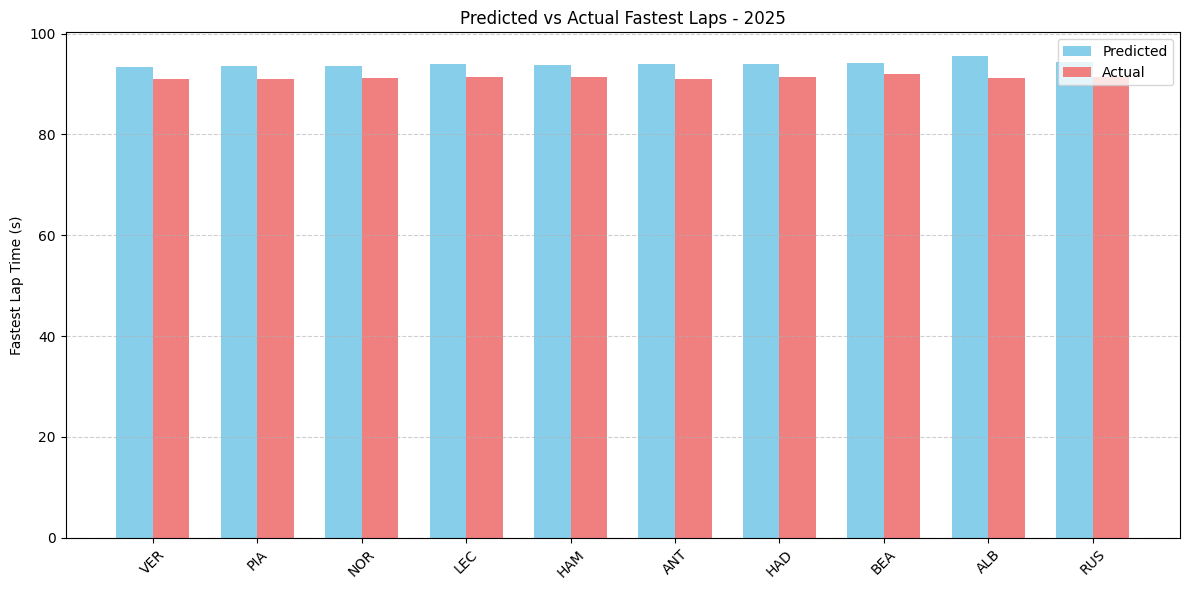

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Actual fastest laps of predicted drivers
actual_laps_2025 = [91.041, 91.039, 91.116, 91.469, 91.406, 90.965, 91.317, 92.006, 91.125, 91.357]

# Driver names for x-axis
drivers = X_2025["Abbreviation"].values

# Lap times that model predicted
predicted_laps_2025 = X_2025["PredictedFastestLap"]

# Customization of the graph
x = np.arange(len(drivers))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, predicted_laps_2025, width, label='Predicted', color='skyblue')
plt.bar(x + width/2, actual_laps_2025, width, label='Actual', color='lightcoral')

plt.xticks(x, drivers, rotation=45)
plt.ylabel("Fastest Lap Time (s)")
plt.title("Predicted vs Actual Fastest Laps - 2025")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



<p style="text-align: left; font-size: 16px; color: #555; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    Okay, this does look awesome. Finally, let's see how did each driver improve. Blue bars are predicted based on 2023 and 2024 seasons, while prediction (the red bars) based on new data from 2025. In some sense, this shows how much did Formula 1 cars improve, since drivers can't be too different from last years (of course, this matters, but not more than an actual vehicle). This is the reason we used time ratio as a feature. Next line graph shows who improved how much.
</p>


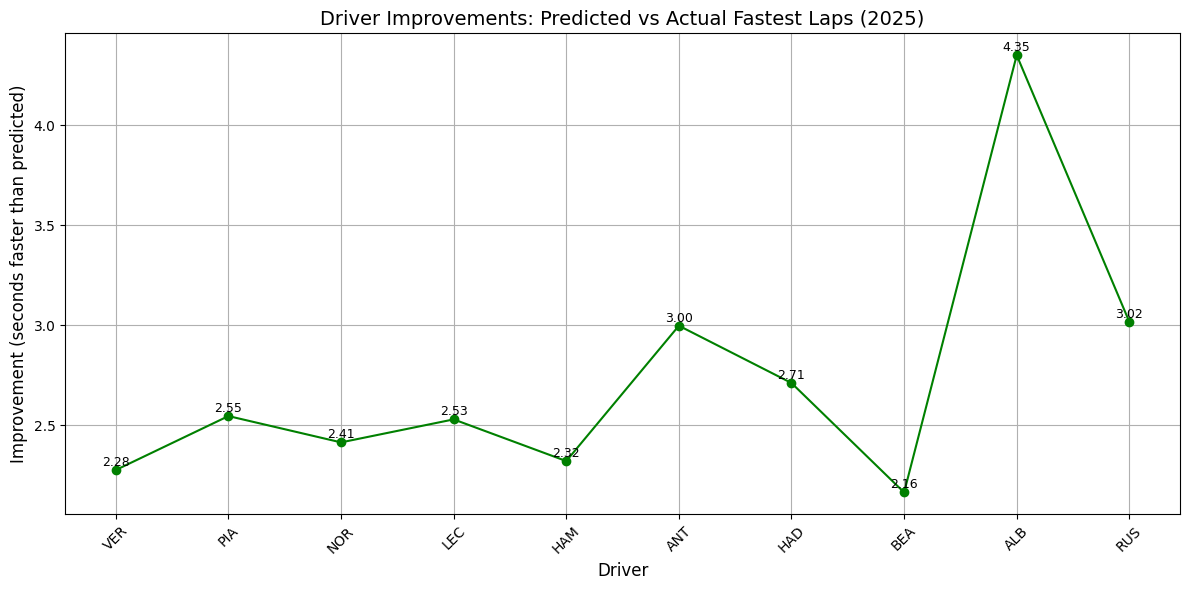

In [13]:
import matplotlib.pyplot as plt

# Difference in prediction and actual laps
improvments = predicted_laps_2025 - actual_laps_2025
X_2025["Improvments"] = improvments

# Plotting improvements
plt.figure(figsize=(12, 6))
plt.plot(X_2025["Abbreviation"], X_2025["Improvments"], marker='o', linestyle='-', color='green')

# Add value labels on each point
for i, value in enumerate(X_2025["Improvments"]):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=9)

# Labels and title
plt.title("Driver Improvements: Predicted vs Actual Fastest Laps (2025)", fontsize=14)
plt.xlabel("Driver", fontsize=12)
plt.ylabel("Improvement (seconds faster than predicted)", fontsize=12)

# Add grid and rotate x-axis labels for clarity
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


<p style="text-align: left; font-size: 16px; color: #555; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
   Great! Seems like Alexander Albon and Williams did a good job in 2025. It is perfectly normal for everyone to have faster times. Technology is improving rapidly and drivers are getting more experience each race.
</p>


## Outro

That's all folks. Thank you for taking your time to view this project and support us that way. Be sure that we will come back with another project, with more knowledge, better ideas and of course, just as our drivers, more experience! 
Every critic and comment is welcome, as well as a request for a collaboration. Let's code together!


<img src="Image/vet.jpg" style="display: block; margin-left: auto; margin-right: auto; width: 100%;" />